<a href="https://colab.research.google.com/github/Marcello-Bacchi/ML_exam_unipv/blob/main/MLP_and_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resonances classification via MLP and CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Train and validation data preparation


In [2]:
! git clone https://github.com/Marcello-Bacchi/ML_exam_unipv.git
! curl https://github.com/Marcello-Bacchi/ML_exam_unipv.git

Cloning into 'ML_exam_unipv'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 122 (delta 9), reused 24 (delta 5), pack-reused 87
Receiving objects: 100% (122/122), 157.32 MiB | 25.98 MiB/s, done.
Resolving deltas: 100% (87/87), done.
<html>
<head><title>301 Moved Permanently</title></head>
<body>
<center><h1>301 Moved Permanently</h1></center>
<hr><center>nginx</center>
</body>
</html>


In [3]:
datafile = '/content/ML_exam_unipv/resonances_dataset.h5'

f = h5py.File(datafile)
print(f.keys())

<KeysViewHDF5 ['resonances']>


![](https://raw.githubusercontent.com/Marcello-Bacchi/ML_exam_unipv/main/lorentz.png)

![](https://raw.githubusercontent.com/Marcello-Bacchi/ML_exam_unipv/main/fano_symm.png)

![](https://raw.githubusercontent.com/Marcello-Bacchi/ML_exam_unipv/main/fano_dx.png)

![](https://raw.githubusercontent.com/Marcello-Bacchi/ML_exam_unipv/main/fano_sx.png)


In [4]:
##### Define vectors for MLP model ######

features_MLP = np.array(f.get('resonances')[:,0:2000])
target_MLP = np.array(f.get('resonances')[:,-1])

##### Define vectors for CNN model ######

features_CNN = np.reshape(features_MLP,(-1,2000,1))
target_CNN = np.reshape(target_MLP,(-1,1,1))


print(target_MLP.shape, features_MLP.shape)
print(target_CNN.shape, features_CNN.shape)

(3000,) (3000, 2000)
(3000, 1, 1) (3000, 2000, 1)


In [5]:
######### Data shuffle with 2:1 splitting ratio MLP ##########

from sklearn.model_selection import train_test_split
X_train_MLP, X_val_MLP, y_train_MLP, y_val_MLP = train_test_split(features_MLP, target_MLP, test_size=0.33)
print(X_train_MLP.shape, X_val_MLP.shape, y_train_MLP.shape, y_val_MLP.shape)
del features_MLP, target_MLP

(2010, 2000) (990, 2000) (2010,) (990,)


In [6]:
######### Data shuffle with 2:1 splitting ratio CNN ##########

from sklearn.model_selection import train_test_split
X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(features_CNN, target_CNN, test_size=0.33)
print(X_train_CNN.shape, X_val_CNN.shape, y_train_CNN.shape, y_val_CNN.shape)
del features_CNN, target_CNN

(2010, 2000, 1) (990, 2000, 1) (2010, 1, 1) (990, 1, 1)


In [7]:
######## Keras imports for MLP and CNN #########

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation, Conv1D, AveragePooling1D, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

# MLP model

In [8]:
input_shape = X_train_MLP.shape[1]
dropoutRate = 0.25

inputArray = Input(shape=(input_shape))

######### FIRST LAYER ##########
x = Dense(40, activation='LeakyReLU')(inputArray)
x = Dropout(dropoutRate)(x)


######### SECOND LAYER ##########
x = Dense(20)(x)
x = Activation('LeakyReLU')(x)
x = Dropout(dropoutRate)(x)


output_MLP = Dense(1, activation='sigmoid')(x)

model_MLP = Model(inputs=inputArray, outputs=output_MLP)


model_MLP.compile(loss='binary_crossentropy', optimizer='adam')
model_MLP.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 40)                80040     
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 activation (Activation)     (None, 20)                0         
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21    

Leaky ReLU activation function was employed to overcome the vanishing gradient problem. Relu activation function causes the training to stop after few iteration with little changes in the losses. As a result, the accuracy is near 50%.

In [9]:
batch_size = 128
n_epochs_MLP = 100

# train
history_MLP = model_MLP.fit(X_train_MLP, y_train_MLP, epochs=n_epochs_MLP, batch_size=batch_size, verbose = 2,
                validation_data=(X_val_MLP, y_val_MLP),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/100
16/16 - 2s - loss: 0.8225 - val_loss: 0.6822 - lr: 0.0010 - 2s/epoch - 127ms/step
Epoch 2/100
16/16 - 0s - loss: 0.7388 - val_loss: 0.6773 - lr: 0.0010 - 110ms/epoch - 7ms/step
Epoch 3/100
16/16 - 0s - loss: 0.7125 - val_loss: 0.6802 - lr: 0.0010 - 155ms/epoch - 10ms/step
Epoch 4/100
16/16 - 0s - loss: 0.6922 - val_loss: 0.6740 - lr: 0.0010 - 114ms/epoch - 7ms/step
Epoch 5/100
16/16 - 0s - loss: 0.6904 - val_loss: 0.6674 - lr: 0.0010 - 109ms/epoch - 7ms/step
Epoch 6/100
16/16 - 0s - loss: 0.6760 - val_loss: 0.6580 - lr: 0.0010 - 136ms/epoch - 8ms/step
Epoch 7/100
16/16 - 0s - loss: 0.6718 - val_loss: 0.6525 - lr: 0.0010 - 114ms/epoch - 7ms/step
Epoch 8/100
16/16 - 0s - loss: 0.6729 - val_loss: 0.6874 - lr: 0.0010 - 122ms/epoch - 8ms/step
Epoch 9/100
16/16 - 0s - loss: 0.6733 - val_loss: 0.6469 - lr: 0.0010 - 119ms/epoch - 7ms/step
Epoch 10/100
16/16 - 0s - loss: 0.6589 - val_loss: 0.6420 - lr: 0.0010 - 115ms/epoch - 7ms/step
Epoch 11/100
16/16 - 0s - loss: 0.6586 - val_loss

# Results MLP

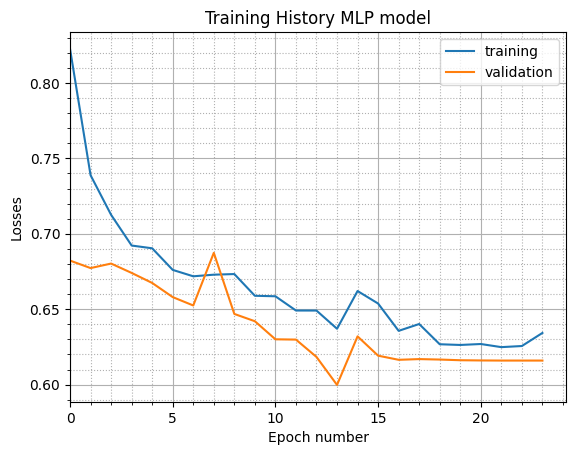

In [10]:
# plot training history
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
#plt.yscale('log')
#plt.semilogy()
plt.title('Training History MLP model')
plt.ylabel('Losses')
plt.xlabel('Epoch number')
plt.legend(['training', 'validation'], loc='upper right')
plt.xlim(left=0)
plt.minorticks_on()
plt.tick_params(which='both', direction='out')
plt.grid(True, which='major')
plt.grid(True, which='minor', linestyle=':')
plt.show()

31/31 [==============================] - 0s 2ms/step


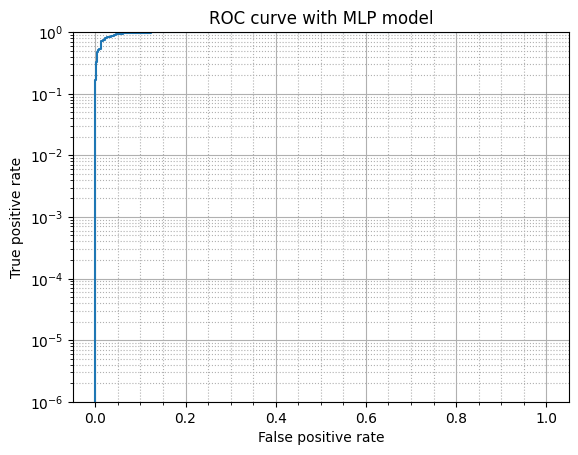

Accuracy = 98.38%


In [11]:
from sklearn.metrics import roc_curve, auc

predict_val_MLP = model_MLP.predict(X_val_MLP)

fpr_MLP = {}
tpr_MLP = {}
auc_MLP = {}

fpr_MLP, tpr_MLP, threshold = roc_curve(y_val_MLP, predict_val_MLP)
auc_MLP = auc(fpr_MLP, tpr_MLP)

plt.plot(fpr_MLP, tpr_MLP)
plt.semilogy()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve with MLP model')
plt.ylim(0.000001,1)
plt.minorticks_on()
plt.tick_params(which='both', direction='out')
plt.grid(True, which='major')
plt.grid(True, which='minor', linestyle=':')
plt.show()

print('Accuracy = '+str(np.round(auc_MLP*100,2))+'%')

# CNN model

In [12]:
featureArrayLength = (X_train_CNN.shape[1],X_train_CNN.shape[2])
dropoutRate = 0.25


inputList = Input(shape=(featureArrayLength))
x = Conv1D(5, kernel_size=3, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
x = AveragePooling1D(pool_size=3)(x)
x = Flatten()(x)

####### First layer ########
x = Dense(25, activation='relu')(x)
x = Dropout(dropoutRate)(x)

####### Second layer ########
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)

output_CNN = Dense(1, activation='sigmoid')(x)
model_CNN = Model(inputs=inputList, outputs=output_CNN)

model_CNN.compile(loss='binary_crossentropy', optimizer='adam')
model_CNN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1998, 5)           20        
                                                                 
 average_pooling1d (AverageP  (None, 666, 5)           0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 3330)              0         
                                                                 
 dense_3 (Dense)             (None, 25)                83275     
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                           

In [13]:
batch_size = 128
n_epochs_CNN = 100

# train
history_CNN = model_CNN.fit(X_train_CNN, y_train_CNN, epochs=n_epochs_CNN, batch_size=batch_size, verbose = 2,
                validation_data=(X_val_CNN, y_val_CNN),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/100
16/16 - 4s - loss: 0.7030 - val_loss: 0.6877 - lr: 0.0010 - 4s/epoch - 227ms/step
Epoch 2/100
16/16 - 1s - loss: 0.6843 - val_loss: 0.6843 - lr: 0.0010 - 992ms/epoch - 62ms/step
Epoch 3/100
16/16 - 1s - loss: 0.6799 - val_loss: 0.6812 - lr: 0.0010 - 1s/epoch - 67ms/step
Epoch 4/100
16/16 - 1s - loss: 0.6771 - val_loss: 0.6788 - lr: 0.0010 - 979ms/epoch - 61ms/step
Epoch 5/100
16/16 - 1s - loss: 0.6726 - val_loss: 0.6745 - lr: 0.0010 - 1s/epoch - 68ms/step
Epoch 6/100
16/16 - 1s - loss: 0.6682 - val_loss: 0.6719 - lr: 0.0010 - 1s/epoch - 64ms/step
Epoch 7/100
16/16 - 1s - loss: 0.6637 - val_loss: 0.6687 - lr: 0.0010 - 1s/epoch - 68ms/step
Epoch 8/100
16/16 - 1s - loss: 0.6623 - val_loss: 0.6655 - lr: 0.0010 - 1s/epoch - 63ms/step
Epoch 9/100
16/16 - 1s - loss: 0.6571 - val_loss: 0.6604 - lr: 0.0010 - 1s/epoch - 63ms/step
Epoch 10/100
16/16 - 1s - loss: 0.6497 - val_loss: 0.6568 - lr: 0.0010 - 1s/epoch - 63ms/step
Epoch 11/100
16/16 - 2s - loss: 0.6498 - val_loss: 0.6537 - lr

# CNN results

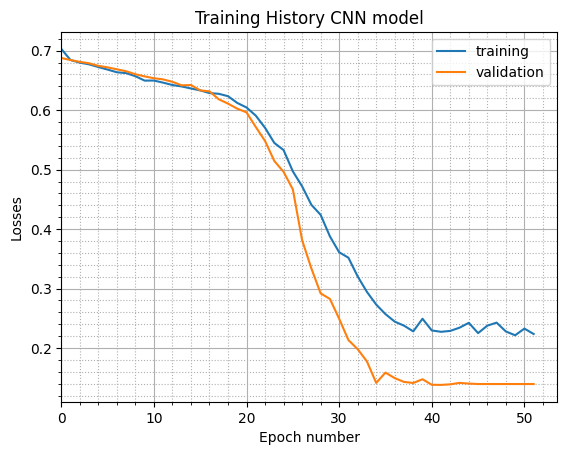

In [14]:
# plot training history
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('Training History CNN model')
plt.ylabel('Losses')
plt.xlabel('Epoch number')
plt.legend(['training', 'validation'], loc='upper right')
plt.xlim(left=0)
plt.minorticks_on()
plt.tick_params(which='both', direction='out')
plt.grid(True, which='major')
plt.grid(True, which='minor', linestyle=':')
plt.show()

31/31 [==============================] - 0s 9ms/step


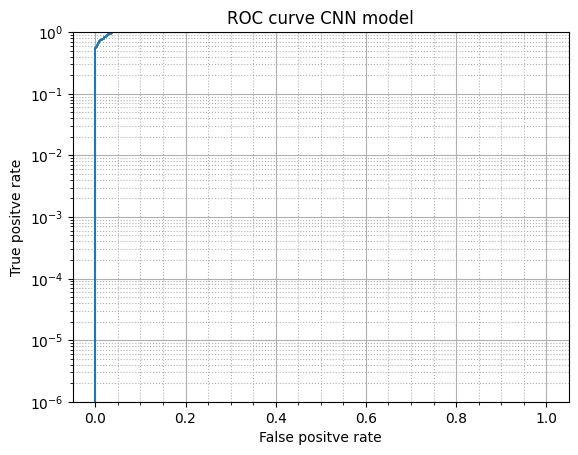

Accuracy = 99.22%


In [15]:
from sklearn.metrics import roc_curve, auc

predict_val_CNN = model_CNN.predict(X_val_CNN)
y_val_CNN = np.reshape(y_val_CNN,(990,1))
fpr_CNN = {}
tpr_CNN = {}
auc_CNN = {}

fpr_CNN, tpr_CNN, threshold = roc_curve(y_val_CNN, predict_val_CNN)
auc_CNN = auc(fpr_CNN, tpr_CNN)

plt.plot(fpr_CNN, tpr_CNN)
plt.semilogy()
plt.xlabel("False positve rate")
plt.ylabel("True positve rate")
plt.title('ROC curve CNN model')
plt.ylim(0.000001,1)
plt.minorticks_on()
plt.tick_params(axis='x', which='both', direction='out')
plt.grid(True, which='major')
plt.grid(True, which='minor', linestyle=':')
#plt.legend(loc='lower right')
plt.show()

print('Accuracy = '+str(np.round(auc_CNN*100,2))+'%')

# Comparative results

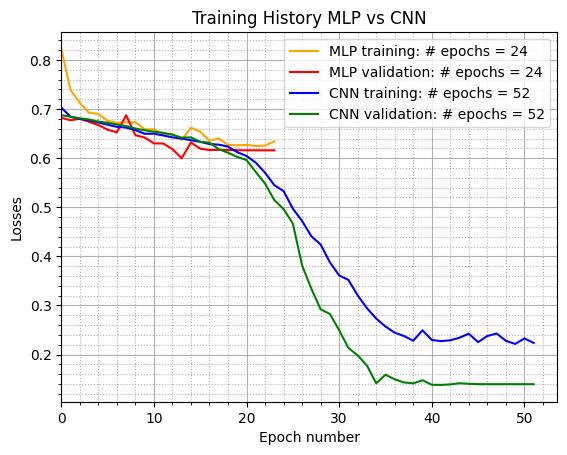

In [16]:
plt.plot(history_MLP.history['loss'], color='orange')
plt.plot(history_MLP.history['val_loss'], color='red')
plt.plot(history_CNN.history['loss'], color='blue')
plt.plot(history_CNN.history['val_loss'], color='green')
plt.title('Training History MLP vs CNN')
plt.ylabel('Losses')
plt.xlabel('Epoch number')
plt.legend(['MLP training: # epochs = '+str(len(history_MLP.history['loss'])), 'MLP validation: # epochs = '+str(len(history_MLP.history['loss'])), 'CNN training: # epochs = '+str(len(history_CNN.history['loss'])), 'CNN validation: # epochs = '+str(len(history_CNN.history['loss']))], loc='upper right')
plt.xlim(left=0)
plt.minorticks_on()
plt.tick_params(which='both', direction='out')
plt.grid(True, which='major')
plt.grid(True, which='minor', linestyle=':')
plt.show()

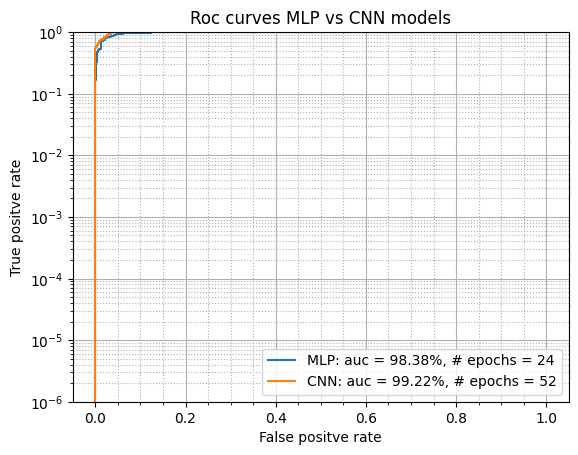

In [17]:
plt.plot(fpr_MLP, tpr_MLP, label='MLP: auc = '+str(np.round(auc_MLP*100,2))+'%, # epochs = '+str(len(history_MLP.history['loss'])))
plt.plot(fpr_CNN, tpr_CNN, label='CNN: auc = '+str(np.round(auc_CNN*100,2))+'%, # epochs = '+str(len(history_CNN.history['loss'])))
plt.semilogy()
plt.xlabel("False positve rate")
plt.ylabel("True positve rate")
plt.title('Roc curves MLP vs CNN models')
plt.ylim(0.000001,1)
plt.minorticks_on()
plt.tick_params(axis='x', which='both', direction='out')
plt.grid(True, which='major')
plt.grid(True, which='minor', linestyle=':')
plt.legend(loc='lower right')
plt.show()